<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Como podemos otimizar as entregas para torna-las mais eficientes? há uma necessidade de uma maior eficiência nas entrega onde será preciso uma melhor distribuição de frotas pra melhor atender as regiões de acordo com a demanda. Usando o python e seus pacotes específicos, poderemos tratar os dados obtidos, realizar sua vizualização gráfica e via mapa com coordenadas geográficas. Com essas informações será possível mapear as entregas de acordo com as regiões e realizar insights para atender a necessidade solicitada.

## 2\. Pacotes e bibliotecas

In [ ]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
#

# - 1º pacotes nativos do python: json, os, etc.;
import json

# - 2º pacotes de terceiros: pandas, seabornm etc.;
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt



3° Dicionário de variáveis e DataFrames;
solucao - variável criada para transformar o arquivo json
deliveries_df - criação do data frame para entregas
hub_origin_df - criado para realiar o tratamento de colunas
hub_df - dataframe criado para manipular dados
hub_geodata_df - dataframe criado para utilizar coordenadas geográficas
mapa - variável criada para gerar visualizações usando coordenas geográficas e o mapa do Distrito Federal


## 3\. Exploração de dados

In [ ]:
# faça o código de exploração de dados:
#
# - coleta de dados;
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
with open('deliveries.json', mode='r', encoding='utf8') as file:
  solucao = json.load(file)
# - wrangling da estrutura;
deliveries_df = pd.DataFrame(solucao)
# - tratamento de colunas
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
pd.json_normalize(pd.DataFrame(deliveries_exploded_df["deliveries"])), [deliveries_exploded_df]

# - combinação de dados
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)



In [ ]:
# - schema da exploração
deliveries_df.head(n=5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
# - colunas e seus dados correspondentes
deliveries_df.dtypes

,0
name,object
region,object
hub_lng,float64
hub_lat,float64
vehicle_capacity,int64
delivery_size,int64
delivery_lng,float64
delivery_lat,float64


In [ ]:
# - atributos categóricos
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
# - atributos numéricos
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


## 4\. Manipulação

In [ ]:
# faça o código de manipulação de dados:
#
# - enriquecimento;
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index( drop=True )

import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745" )
print(json.dumps(location.raw, indent=2, ensure_ascii=False))

from geopy.extra.rate_limiter import RateLimiter
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", "
hub_df["coordinates"] = hub_df["coordinates"] + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply( lambda data: data.raw ))

hub_geodata_df = hub_geodata_df[ ["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename( columns={ "address.town": "hub_town", "address.suburb" : "hub_suburb", "address.city": "hub_city" }, inplace=True)
hub_geodata_df["hub_city"] = np.where( hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"] )
hub_geodata_df["hub_suburb"] = np.where( hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

hub_df = pd.merge( left=hub_df, right=hub_geodata_df, left_index=True, right_index=True )
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

deliveries_df = pd.merge( left=deliveries_df, right=hub_df, how="inner", on="region" )
deliveries_df = deliveries_df[[ "name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat" ]]
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv In [ ]

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv" )

deliveries_df = pd.merge( left=deliveries_df, right=deliveries_geodata_df [["delivery_city",  "delivery_suburb" ]], how="inner", left_index=True, right_index=True )

# - controle de qualidade;
deliveries_df.info()
# faça o código de manipulação de dados:
#
# - enriquecimento;
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index( drop=True )

import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745" )



In [ ]:
deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
hub_city,False
hub_suburb,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


In [ ]:
100 * ( deliveries_df["delivery_city"].isna().sum() / len(deliveries_df) )

0.26754738276724477

In [ ]:
100 * ( deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df) )

25.133262804783158

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts( ) / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_city,
Brasília,0.234195
Taguatinga,0.071625
Sudoeste / Octogonal,0.069504
Ceilândia,0.059661
Águas Claras,0.058293
Guará,0.055619
Lago Sul,0.045620
Sobradinho,0.045412
Lago Norte,0.040832


In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts( ) / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_suburb,
Brasília,0.084564
Asa Norte,0.076639
Taguatinga,0.063363
Asa Sul,0.059263
Águas Claras,0.056598
Guará,0.055619
Samambaia,0.026514
Sobradinho,0.018148
Recanto das Emas,0.015029


## 5\. Visualização

In [ ]:
!pip install geopandas
import geopandas

# faça o código de visualização de dados:
# - produza pelo menos duas visualizações;

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates( ).reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame( hub_df, geometry=geopandas.points_from_xy( hub_df["hub_lng"], hub_df["hub_lat"] ) )

geo_deliveries_df = geopandas.GeoDataFrame( deliveries_df, geometry=geopandas.points_from_xy( deliveries_df["delivery_lng"], deliveries_df["delivery_lat"] ) )


<Axes: >

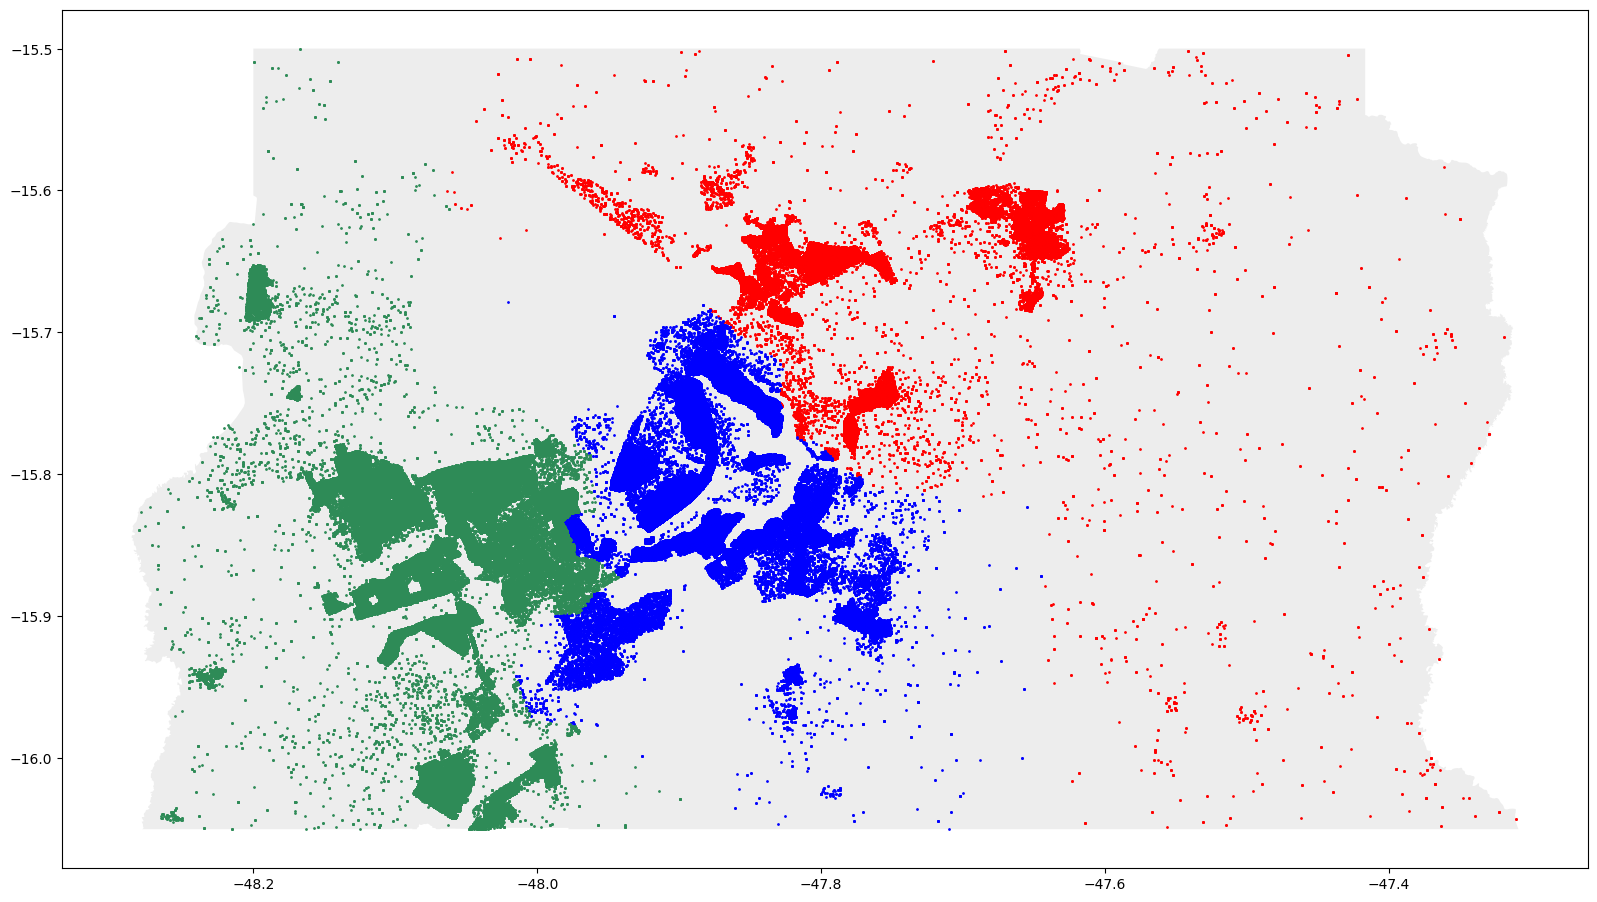

In [ ]:
# - gráfico plot de entregas
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")
geo_deliveries_df.query("region == 'df-0'").plot( ax=ax, markersize=1, color="red", label="df-0" )
geo_deliveries_df.query("region == 'df-1'").plot( ax=ax, markersize=1, color="blue", label="df-1" )
geo_deliveries_df.query("region == 'df-2'").plot( ax=ax, markersize=1, color="seagreen", label="df-2" )

Ao analisar o gráfico de entregas, pode-se notar uma grande concentração de entregas próximas aos respectivos hubs. Uma pequena porção das entregas que se afastam mais dos hubs. Sendo assim, para poder otimizar as entregas, será necessário manter a concentração maior próximos aos hubs e nos locais afastados, reorganizar as entregas para maior eficiência como por exemplo carros com capacidade menor por conta do menor volume de entrega. Carros menores poderão se deslocar mais rapidamente e consumirão menos combustível para as entregas. Proporcionando uma economia e otimizando as entregas nas regiões periféricas.

<ipython-input-26-accc8ec14b9b>:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


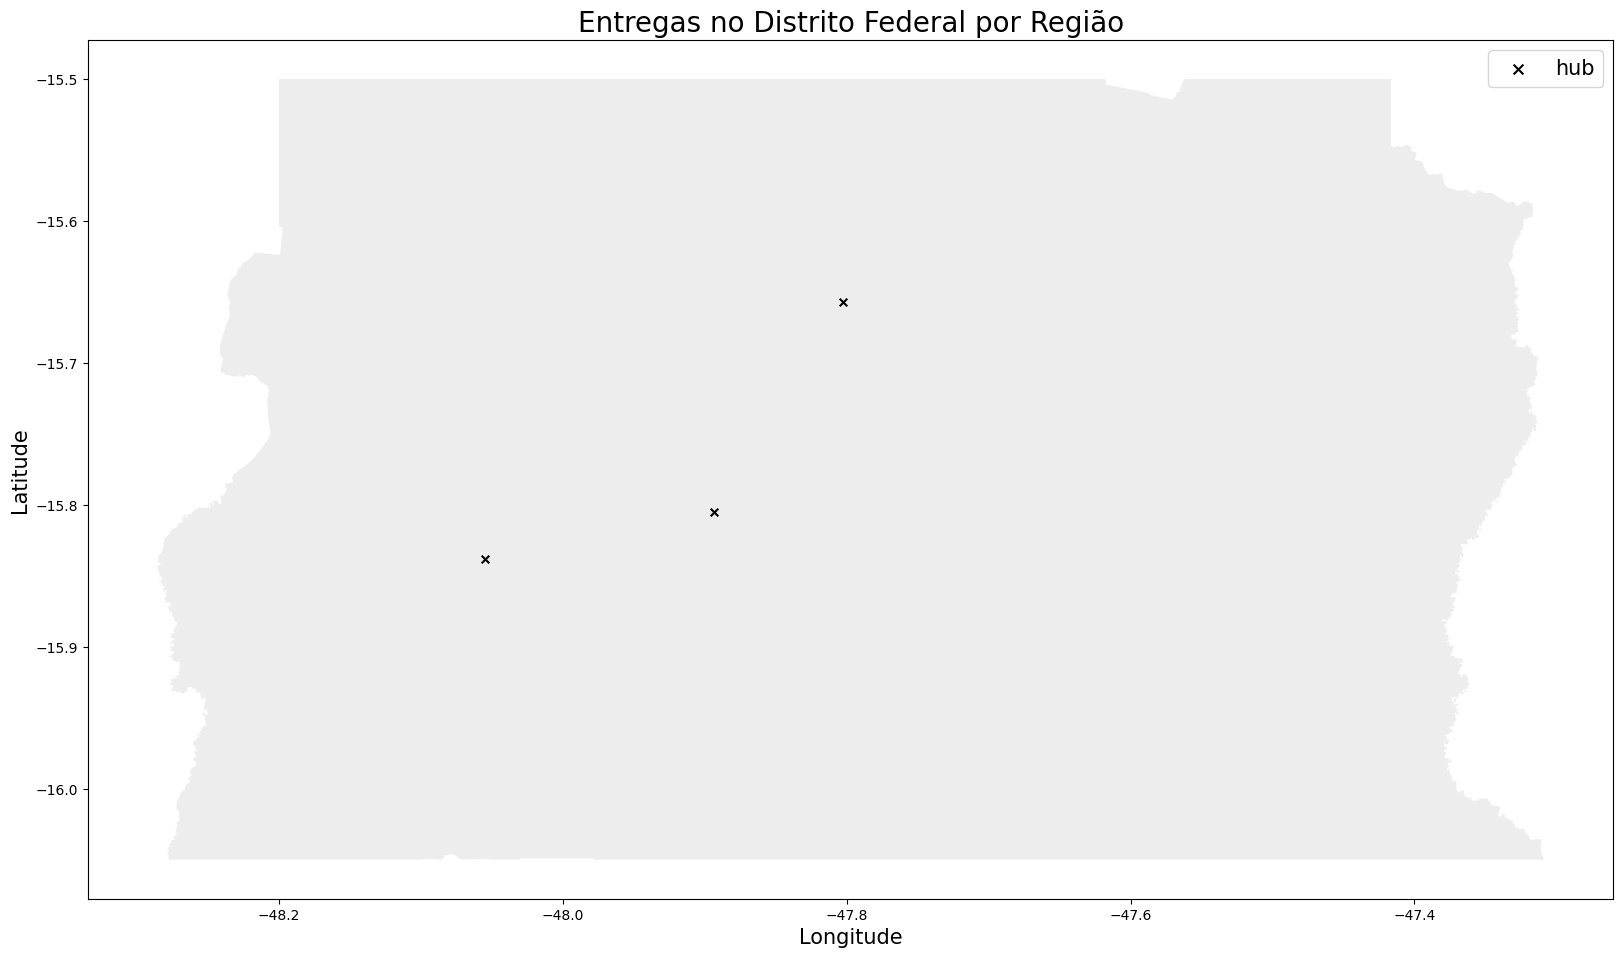

In [ ]:
# - gráfico plot de hub

fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

geo_hub_df.plot( ax=ax, markersize=30, marker="x", color="black", label="hub" )
plt.title( "Entregas no Distrito Federal por Região" , fontdict={"fontsize" : 20})
plt.xlabel( "Longitude", fontdict={"fontsize" : 15})
plt.ylabel( "Latitude", fontdict={"fontsize" : 15})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
 handle.set_sizes([50])

data = pd.DataFrame( deliveries_df[['region',  'vehicle_capacity']].value_counts(normalize=True ).reset_index() )
data.rename(columns={0: "region_percent"}, inplace=True)


O gráfico acima nos mostra claramente onde estão localizados os hubs de distribuição. Pode-se notar que os hubs estão distribuídos efetivamente nos pontos centrais das regiões, facilitando a distribuição da frota e das entregas pela região e zonas periféricas.